In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
    dropfeat = [i.replace('\n','') for i in d.readlines()]

In [3]:
with open('test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)
    
print(len(train_ind),len(test_ind))    


70 30


/tmp/ipykernel_10946/2691449218.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  test_ind = pickle.load(handle)
/tmp/ipykernel_10946/2691449218.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the 

In [4]:
len(train_ind)*len(glob('H*')),len(test_ind)*len(glob('H*'))

(700, 300)

In [5]:
len(train_ind)*len([i for i in glob('H*') if '12' not in i]),len(test_ind)*len([i for i in glob('H*') if '12' not in i])

(630, 270)

In [6]:
train = []
test = []



recover_train = []
recover_test = []

traincnt = 0
testcnt = 0
for i in sorted(glob('H*')):
    print(i)
    try:
        if int(i.split('_')[0].strip('H'))<=12 and os.path.isdir(i):
            for j in glob(os.path.join(i,'H*')):
                for k in train_ind:
                    if f"{k:.2f}" in j:
                        traindf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0).rename(columns={'1':'$\mathbf{b}$'})
                        train.append(traindf)
                        recover_train.append((i,f"{k:.2f}",traincnt,len(traindf)))
                        traincnt+=1
                        
                for l in test_ind:
                    if f"{l:.2f}" in j:
                        testdf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0).rename(columns={'1':'$\mathbf{b}$'})
                        test.append(testdf)                    
                        recover_test.append((i,f"{l:.2f}",testcnt,len(testdf)))
                        testcnt+=1
    except:
        pass

H10_chain
H12_chain
H14_chain
H2_chain
H2n_VDZP_params.xlsx
H2n_params.xlsx
H4_chain
H6_chain
H8_chain
Hn_SHAP.xlsx


In [7]:
rename = {'h$_{qq}^{0}$':'h$_{q}$',
'$(F_{q})_{0}$':'$F_{q}$',
'$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
'$(\\eta_{q})_{0}$':'$\\eta_{q}$',
'$(\\omega_{q})_{0}$':'$\\omega_{q}$',
'$(\\eta_{s})_{0}$':'$\\eta_{s}$',
'h$_{ss}^{0}$':'h$_{s}$',
'$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
'$(F_{s})_{0}$':'$F_{s}$',
'$(\\omega_{s})_{0}$':'$\\omega_{s}$',
'$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
'$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
'h$_{pp}^{0}$': '(h$_{p}$)$_{0}$',
'h$_{pp}^{1}$': '(h$_{p}$)$_{1}$',
'h$_{pp}^{2}$': '(h$_{p}$)$_{2}$',
'h$_{pp}^{3}$': '(h$_{p}$)$_{3}$',
'h$_{rr}^{0}$': '(h$_{r}$)$_{0}$',
'h$_{rr}^{1}$': '(h$_{r}$)$_{1}$',
'h$_{rr}^{2}$': '(h$_{r}$)$_{2}$',
'h$_{rr}^{3}$': '(h$_{r}$)$_{3}$',
'h$_{pq}^{0}$':'(h$_{pq}$)$_{0}$',
'h$_{pq}^{1}$':'(h$_{pq}$)$_{1}$',
'h$_{pq}^{2}$':'(h$_{pq}$)$_{2}$',
'h$_{pq}^{3}$':'(h$_{pq}$)$_{3}$',
'h$_{pr}^{0}$':'(h$_{pr}$)$_{0}$',
'h$_{pr}^{1}$':'(h$_{pr}$)$_{1}$',
'h$_{pr}^{2}$':'(h$_{pr}$)$_{2}$',
'h$_{pr}^{3}$':'(h$_{pr}$)$_{3}$',
'h$_{rs}^{0}$':'(h$_{rs}$)$_{0}$',
'h$_{rs}^{1}$':'(h$_{rs}$)$_{1}$',
'h$_{rs}^{2}$':'(h$_{rs}$)$_{2}$',
'h$_{rs}^{3}$':'(h$_{rs}$)$_{3}$',
'typ_0':'$type_0$',
'typ_1':'$type_1$',
'typ_2':'$type_2$',
'typ_3':'$type_3$'}

In [8]:
# dffeat = pd.read_excel('Hn_SHAP.xlsx',index_col=0).sort_values(by='shap',ascending=False)
dffeat = pd.read_excel('Hn_SHAP.xlsx')

In [9]:
# with open('feature_names.txt','r') as f:
#     for i in sorted(f.readlines()):
#         print(i)

In [10]:
maes = {}
r2s = {}
for featlen in np.arange(17,dffeat.shape[0]+17,17):
    feat_shap = dffeat['feat'].iloc[0:featlen].values
    
    print(len(feat_shap)/len(dffeat))
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    X_train = train_df[feat_shap].values
    X_test = test_df[feat_shap].values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    kwargs = dict(pd.read_excel("H2n_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for i,j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((i.split("_")[0],j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((i.split("_")[0],j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for i,j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((i.split("_")[0],j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((i.split("_")[0],j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))

    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:'H$_{2n}$',1:'Radius ($\AA$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({'H$_{2n}$':str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:'H$_{2n}$',1:'Radius ($\AA$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({'H$_{2n}$':str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})


    
    traincorrcalc, traincorrpred = traincorrE2['E$_{2}^{\text{Calculated}}$'],traincorrE2['E$_{2}^{\text{Predicted}}$']
    testcorrcalc, testcorrpred = testcorrE2['E$_{2}^{\text{Calculated}}$'],testcorrE2['E$_{2}^{\text{Predicted}}$']
    print(f"R2: {r2_score(traincorrcalc, traincorrpred):.4f},{r2_score(testcorrcalc, testcorrpred):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(traincorrcalc, traincorrpred)*1e3:.4f},{root_mean_squared_error(testcorrcalc, testcorrpred)*1e3:.4f}")
    
    maes[featlen] = {'Train pairs':mean_absolute_error(y_train,y_pred_train)*1e3,'Test pairs':mean_absolute_error(y_test,y_pred_test)*1e3,'Train Corr':mean_absolute_error(traincorrcalc, traincorrpred)*1e3, 'Test Corr':mean_absolute_error(testcorrcalc, testcorrpred)*1e3}
    r2s[featlen] = {'Train pairs':r2_score(y_train,y_pred_train),'Test pairs':r2_score(y_test,y_pred_test),'Train Corr':r2_score(traincorrcalc, traincorrpred), 'Test Corr':r2_score(testcorrcalc, testcorrpred)}
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    traincorrE2.index = ["_".join((u,v)) for u,v in traincorrE2[['H$_{2n}$','Radius ($\AA$)']].values]
    
    for i in traincorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}_chain/{hn}_{r}/{hn}_{r}_energies.xlsx",index_col=0)
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    testcorrE2.index = ["_".join((u,v)) for u,v in testcorrE2[['H$_{2n}$','Radius ($\AA$)']].values]
    
    for i in testcorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}_chain/{hn}_{r}/{hn}_{r}_energies.xlsx",index_col=0)
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)

    

0.16666666666666666
R2: 0.9878,0.9742
RMSE (mEh): 0.1291,0.1979
R2: 0.9982,0.9967
RMSE (mEh): 1.2111,1.8191
0.3333333333333333
R2: 0.9918,0.9847
RMSE (mEh): 0.1061,0.1525
R2: 0.9989,0.9963
RMSE (mEh): 0.9506,1.9348
0.5
R2: 0.9921,0.9846
RMSE (mEh): 0.1037,0.1531
R2: 0.9987,0.9954
RMSE (mEh): 1.0226,2.1445
0.6666666666666666
R2: 0.9925,0.9843
RMSE (mEh): 0.1010,0.1544
R2: 0.9988,0.9951
RMSE (mEh): 0.9826,2.2179
0.8333333333333334
R2: 0.9926,0.9842
RMSE (mEh): 0.1004,0.1548
R2: 0.9990,0.9955
RMSE (mEh): 0.9021,2.1173
1.0
R2: 0.9926,0.9842
RMSE (mEh): 0.1004,0.1548
R2: 0.9990,0.9955
RMSE (mEh): 0.9021,2.1173


In [11]:
maecurve = pd.DataFrame(maes).T.reset_index()
mae_pair_df = maecurve[['index','Train pairs','Test pairs']].rename(columns={'index':'Number of Features','Train pairs':'Train','Test pairs':'Test'}).melt(id_vars=['Number of Features'], value_vars=['Train','Test'])
mae_corr_df = maecurve[['index','Train Corr','Test Corr']].rename(columns={'index':'Number of Features','Train Corr':'Train','Test Corr':'Test'}).melt(id_vars=['Number of Features'], value_vars=['Train','Test'])

In [12]:
r2curve = pd.DataFrame(r2s).T.reset_index()
r2_pair_df = r2curve[['index','Train pairs','Test pairs']].rename(columns={'index':'Number of Features','Train pairs':'Train','Test pairs':'Test'}).melt(id_vars=['Number of Features'], value_vars=['Train','Test'])
r2_corr_df = r2curve[['index','Train Corr','Test Corr']].rename(columns={'index':'Number of Features','Train Corr':'Train','Test Corr':'Test'}).melt(id_vars=['Number of Features'], value_vars=['Train','Test'])

In [13]:
for featlen in np.arange(17,dffeat.shape[0]+17,17):
    dfcheck = dffeat['feat'].iloc[0:featlen]
    feat_shap = dfcheck.values
    print(len(feat_shap)/len(dffeat),len(feat_shap),f"{dffeat.iloc[0:featlen]['shap'].min():.4e}")
    print()

0.16666666666666666 17 2.3126e-05

0.3333333333333333 34 7.8961e-06

0.5 51 3.9315e-06

0.6666666666666666 68 1.9281e-06

0.8333333333333334 85 2.3731e-09

1.0 102 0.0000e+00



In [14]:
r2curve

,index,Train pairs,Test pairs,Train Corr,Test Corr
0,17,0.987794,0.974213,0.998246,0.996712
1,34,0.991753,0.984695,0.998920,0.996280
2,51,0.992118,0.984569,0.998750,0.995430
3,68,0.992524,0.984300,0.998846,0.995112
4,85,0.992615,0.984220,0.999027,0.995545
5,102,0.992615,0.984220,0.999027,0.995545


In [15]:
r2curve[r2curve['index']==34].round(4)

,index,Train pairs,Test pairs,Train Corr,Test Corr
1,34,0.9918,0.9847,0.9989,0.9963


In [16]:
r2curve[r2curve['index']==102].round(4)

,index,Train pairs,Test pairs,Train Corr,Test Corr
5,102,0.9926,0.9842,0.999,0.9955


In [17]:
maecurve[maecurve['index']==34].round(4)

,index,Train pairs,Test pairs,Train Corr,Test Corr
1,34,0.0751,0.0912,0.6228,1.0636


In [18]:
maecurve[maecurve['index']==102].round(4)

,index,Train pairs,Test pairs,Train Corr,Test Corr
5,102,0.0714,0.0895,0.5753,1.0957


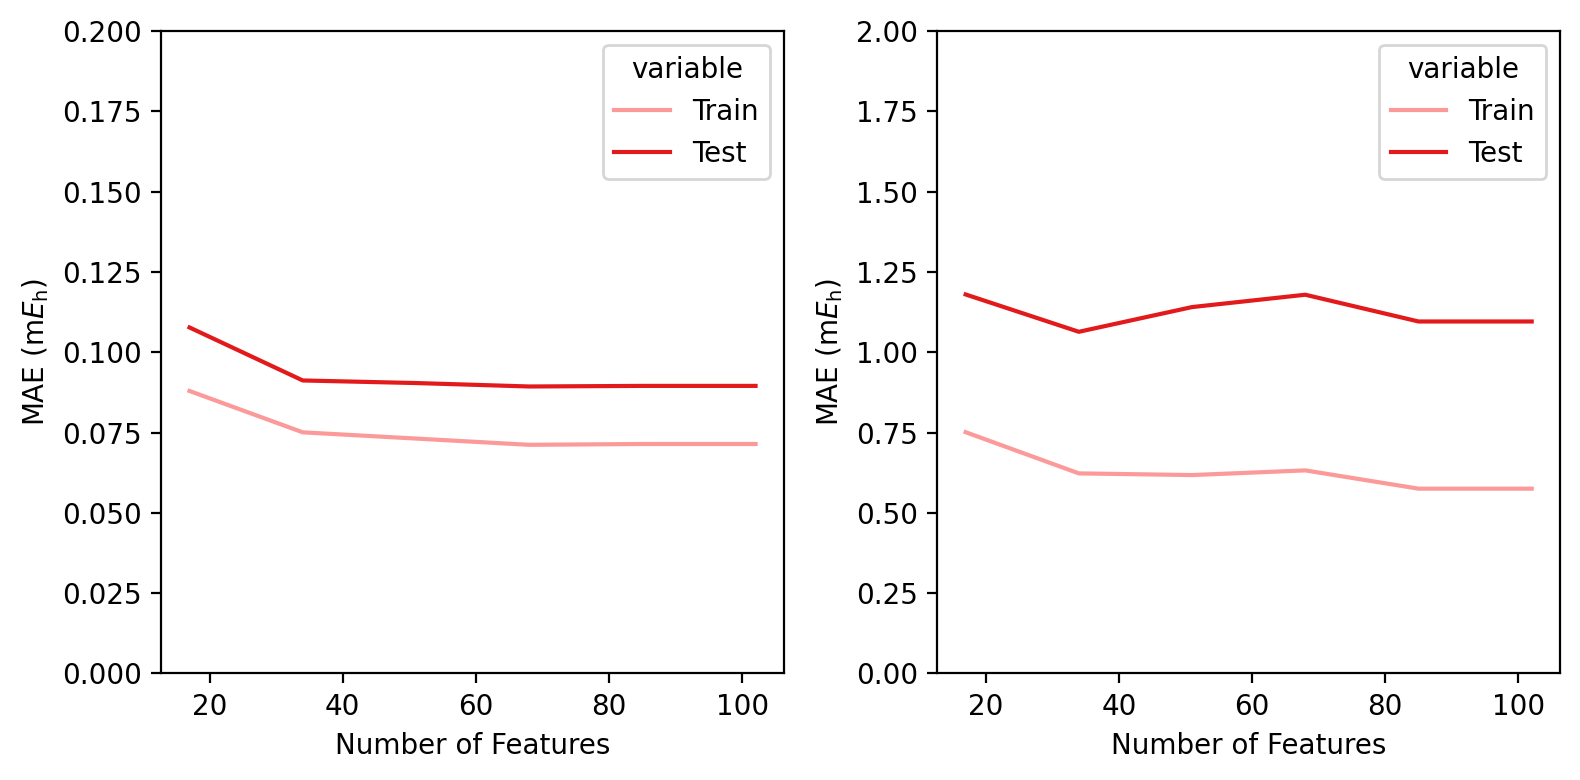

In [19]:
# pairedcp=sns.color_palette('Paired')
# fig, ax = plt.subplots(2,2,sharex=True)
# sns.lineplot(r2_pair_df,x='Number of Features',y='value', hue='variable',ax=ax[0][0],palette=pairedcp[4:6])
# sns.lineplot(r2_corr_df,x='Number of Features',y='value', hue='variable',ax=ax[0][1],markers='x',palette=pairedcp[4:6])
# ax[0][0].set_title(r'Pair-Energies ($\varepsilon_{qs}$)')
# ax[0][1].set_title(r'Correlation Energies (E$_{2}$)')
# ax[0][0].set_ylim(0.9,1.01)
# ax[0][1].set_ylim(0.9,1.01)
# ax[0][0].set_ylabel("R$^{2}$")
# ax[0][1].set_ylabel("R$^{2}$")
# sns.lineplot(mae_pair_df,x='Number of Features',y='value', hue='variable',ax=ax[1][0],palette=pairedcp[4:6])
# ax[1][0].set_ylim(0,0.5)
# sns.lineplot(mae_corr_df,x='Number of Features',y='value', hue='variable',ax=ax[1][1],palette=pairedcp[4:6])
# ax[1][1].set_ylim(0,2)
# ax[1][0].set_ylabel("MAE (m$E_{\mathrm{h}}$)")
# ax[1][1].set_ylabel("MAE (m$E_{\mathrm{h}}$)")
# plt.tight_layout()
# plt.savefig('images/shap_curves.png',dpi=300,bbox_inches='tight')


pairedcp=sns.color_palette('Paired')
fig, ax = plt.subplots(1,2,sharex=True,figsize=(8,4))
# sns.lineplot(r2_pair_df,x='Number of Features',y='value', hue='variable',ax=ax[0][0],palette=pairedcp[4:6])
# sns.lineplot(r2_corr_df,x='Number of Features',y='value', hue='variable',ax=ax[0][1],markers='x',palette=pairedcp[4:6])
# ax[0][0].set_title(r'Pair-Energies ($\varepsilon_{qs}$)')
# ax[0][1].set_title(r'Correlation Energies (E$_{2}$)')
# ax[0][0].set_ylim(0.9,1.01)
# ax[0][1].set_ylim(0.9,1.01)
# ax[0][0].set_ylabel("R$^{2}$")
# ax[0][1].set_ylabel("R$^{2}$")
sns.lineplot(mae_pair_df,x='Number of Features',y='value', hue='variable',ax=ax[0],palette=pairedcp[4:6])
ax[0].set_ylim(0,0.2)
sns.lineplot(mae_corr_df,x='Number of Features',y='value', hue='variable',ax=ax[1],palette=pairedcp[4:6])
ax[1].set_ylim(0,2)
ax[0].set_ylabel("MAE (m$E_{\mathrm{h}}$)")
ax[1].set_ylabel("MAE (m$E_{\mathrm{h}}$)")
plt.tight_layout()
plt.savefig('images/shap_curves.png',dpi=300,bbox_inches='tight')